In [60]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [61]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [62]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/figures/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

## Open FLUXCOM data
Carbon and Energy Fluxes (RS_METEO) based on WFDEI climatological forcing dataset (https://rda.ucar.edu/datasets/ds314.2/), covering the period 197901 - 201312

GPP is DOWNWARD flux of Carbon (out of atmosphere) \
TER is UPWARD flux of Carbon (into the atmosphere) \
NEP in FLUXCOM represents UPWARD flux of Carbon (into atmosphere) whereas in ESM represents DOWNWARD flux of carbon (out of atmosphere)

In [63]:
data_path = 'F:/Data/Reanalysis/'               

# Carbon Fluxes
file = "nee_wfdei_197901-201312.nc" 
ds_nep_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_nep_flux = ds_nep_flux.isel(lat=slice(None, None, -1))

file = "ter_wfdei_197901-201312.nc" 
ds_ter_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_ter_flux = ds_ter_flux.isel(lat=slice(None, None, -1))

file = "gpp_wfdei_197901-201312.nc" 
ds_gpp_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_gpp_flux = ds_gpp_flux.isel(lat=slice(None, None, -1))
#ds_pr = ds_pr.assign_coords(lat=(ds_pr.lat + 0.5)); 

# Energy Fluxes
file = "h_wfdei_197901-201312.nc" 
ds_h_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_h_flux = ds_h_flux.isel(lat=slice(None, None, -1))

file = "le_wfdei_197901-201312.nc" 
ds_le_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_le_flux = ds_le_flux.isel(lat=slice(None, None, -1))

file = "rn_wfdei_197901-201312.nc" 
ds_rn_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_rn_flux = ds_rn_flux.isel(lat=slice(None, None, -1))


In [64]:
# Convert dataset to dataarray

ds_nep_flux = ds_nep_flux.NEE; ds_ter_flux = ds_ter_flux.TER; ds_gpp_flux = ds_gpp_flux.GPP
ds_h_flux = ds_h_flux.H; ds_le_flux = ds_le_flux.LE; ds_rn_flux = ds_rn_flux.Rn

## Open ERA5 data

Precipitation and Temperature donwloaded from ERA5 reanalyses (0.5x0.5), whereas Soil Moisture and LAI from ERA5-Land reanalyses (0.25x0.25)

In [65]:
data_path = 'F:/Data/Reanalysis/'   

file = "era5_tp_195001-201612_raw_f32.nc" 
ds_pr_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]) #ds_pr = ds_pr.mean(axis=0)
ds_pr_era5 = ds_pr_era5.rename(latitude = "lat", longitude = "lon")
ds_pr_era5 = ds_pr_era5.isel(lat=slice(None, None, -1))

file = "era5_mrso_195001-201812.nc"
ds_mrso_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_mrso_era5 = ds_mrso_era5.rename(latitude = "lat", longitude = "lon")
ds_mrso_era5 = ds_mrso_era5.isel(lat=slice(None, None, -1))

file = "era5_tas_195001-201612_raw_f32.nc"
ds_tas_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_tas_era5 = ds_tas_era5.rename(latitude = "lat", longitude = "lon")
ds_tas_era5 = ds_tas_era5.isel(lat=slice(None, None, -1))

data_path = 'F:/Data/Reanalysis/'   
file = "era5_mrso_195001-201812.nc"
ds_mrso_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_mrso_era5 = ds_mrso_era5.rename(latitude = "lat", longitude = "lon")
ds_mrso_era5 = ds_mrso_era5.isel(lat=slice(None, None, -1))

In [66]:
# Convert dataset to dataarray
ds_pr_era5 = ds_pr_era5.tp; ds_mrso_era5 = ds_mrso_era5.mrso; ds_tas_era5 = ds_tas_era5.t2m

## Open ESM data

### SST

In [12]:
##### ------- Open data (MODEL) ------- #####
data_path = 'F:/Data/analysis/'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*_det.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*_det.nc' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

## Normalization
# for i,item in enumerate(nino34_hist):
#     nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

# for i,item in enumerate(nino34_ssp):
#     nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
# nino34_hist = [a.resample(time="Y", label='right').mean() for a in nino34_hist]
# nino34_ssp = [a.resample(time="Y", label='right').mean() for a in nino34_ssp]

# Convert to dataarray
nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

# Delete useless empty dimension
nino34_hist = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_hist]
nino34_ssp = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_ssp]

# Correct for spurious dimension
for i, item in enumerate(nino34_hist):
    if len(nino34_hist[i].shape)!=1:
        nino34_hist[i] = nino34_hist[i][1]
    else:
        None


### LAND

In [13]:
data_path = 'F:/Data/analysis/'              

Rh

In [14]:
scenario = 'ssp585'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rh):
    ds_ssp_rh[i] = ds_ssp_rh[i].isel(time = slice(0,1032))
    ds_ssp_rh[i] = ds_ssp_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rh[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rh[i] = ds_ssp_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_rh[i] = ds_ssp_rh[i].resample(time="Y", label='right').mean()

In [15]:
scenario = 'historical'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_rh):
    ds_hist_rh[i] = ds_hist_rh[i].isel(time = slice(0,1980))
    ds_hist_rh[i] = ds_hist_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_rh[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_rh[i] = ds_hist_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_rh[i] = ds_hist_rh[i].resample(time="Y", label='right').mean()

Ra

In [16]:
scenario = 'ssp585'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_ra):
    ds_ssp_ra[i] = ds_ssp_ra[i].isel(time = slice(0,1032))
    ds_ssp_ra[i] = ds_ssp_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_ra[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_ra[i] = ds_ssp_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_ra[i] = ds_ssp_ra[i].resample(time="Y", label='right').mean()

In [17]:
scenario = 'historical'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_ra):
    ds_hist_ra[i] = ds_hist_ra[i].isel(time = slice(0,1980))
    ds_hist_ra[i] = ds_hist_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_ra[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_ra[i] = ds_hist_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_ra[i] = ds_hist_ra[i].resample(time="Y", label='right').mean()

GPP

In [18]:
scenario = 'ssp585'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_gpp):
    ds_ssp_gpp[i] = ds_ssp_gpp[i].isel(time = slice(0,1032))
    ds_ssp_gpp[i] = ds_ssp_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_gpp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_gpp[i] = ds_ssp_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_gpp[i] = ds_ssp_gpp[i].resample(time="Y", label='right').mean()

In [19]:
scenario = 'historical'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_gpp):
    ds_hist_gpp[i] = ds_hist_gpp[i].isel(time = slice(0,1980))
    ds_hist_gpp[i] = ds_hist_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_gpp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_gpp[i] = ds_hist_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_gpp[i] = ds_hist_gpp[i].resample(time="Y", label='right').mean()

NEP

In [20]:
scenario = 'ssp585'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nep.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nep):
    ds_ssp_nep[i] = ds_ssp_nep[i].isel(time = slice(0,1032))
    ds_ssp_nep[i] = ds_ssp_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nep[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nep[i] = ds_ssp_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_nep[i] = ds_ssp_nep[i].resample(time="Y", label='right').mean()

In [21]:
scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_nep.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_nep):
    ds_hist_nep[i] = ds_hist_nep[i].isel(time = slice(0,1980))
    ds_hist_nep[i] = ds_hist_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nep[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_nep[i] = ds_hist_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_nep[i] = ds_hist_nep[i].resample(time="Y", label='right').mean()

NBP

In [22]:
scenario = 'ssp585'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nbp):
    ds_ssp_nbp[i] = ds_ssp_nbp[i].isel(time = slice(0,1032))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nbp[i] = ds_ssp_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_nbp[i] = ds_ssp_nbp[i].resample(time="Y", label='right').mean()

In [23]:
scenario = 'historical'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_nbp):
    ds_hist_nbp[i] = ds_hist_nbp[i].isel(time = slice(0,1980))
    ds_hist_nbp[i] = ds_hist_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nbp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_nbp[i] = ds_hist_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_nbp[i] = ds_hist_nbp[i].resample(time="Y", label='right').mean()

Temperature

In [24]:
scenario = 'ssp585'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_tas.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_tas):
    ds_ssp_tas[i] = ds_ssp_tas[i].isel(time = slice(0,1032))
    ds_ssp_tas[i] = ds_ssp_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_tas[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_tas[i] = ds_ssp_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_tas[i] = ds_ssp_tas[i].resample(time="Y", label='right').mean()
    if "height" in ds_ssp_tas[i].coords:
        ds_ssp_tas[i] = ds_ssp_tas[i].drop_vars("height")

In [25]:
scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_tas.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_tas):
    ds_hist_tas[i] = ds_hist_tas[i].isel(time = slice(0,1980))
    ds_hist_tas[i] = ds_hist_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_tas[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_tas[i] = ds_hist_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_tas[i] = ds_hist_tas[i].resample(time="Y", label='right').mean()

Precipitation

In [26]:
scenario = 'ssp585'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_pr.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_pr):
    ds_ssp_pr[i] = ds_ssp_pr[i].isel(time = slice(0,1032))
    ds_ssp_pr[i] = ds_ssp_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_pr[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_pr[i] = ds_ssp_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_pr[i] = ds_ssp_pr[i].resample(time="Y", label='right').sum()


In [27]:
scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_pr.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_pr):
    ds_hist_pr[i] = ds_hist_pr[i].isel(time = slice(0,1980))
    ds_hist_pr[i] = ds_hist_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_pr[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_pr[i] = ds_hist_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_pr[i] = ds_hist_pr[i].resample(time="Y", label='right').sum()

Soil Moisture

In [28]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_mrso.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_mrso):
    ds_ssp_mrso[i] = ds_ssp_mrso[i].isel(time = slice(0,1032))
    ds_ssp_mrso[i] = ds_ssp_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_mrso[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_mrso[i] = ds_ssp_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_mrso[i] = ds_ssp_mrso[i].resample(time="Y", label='right').mean()


In [29]:
scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_mrso.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_mrso):
    ds_hist_mrso[i] = ds_hist_mrso[i].isel(time = slice(0,1980))
    ds_hist_mrso[i] = ds_hist_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_mrso[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_mrso[i] = ds_hist_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_mrso[i] = ds_hist_mrso[i].resample(time="Y", label='right').mean()

SWin

In [30]:
scenario = 'ssp585'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rsds.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rsds):
    ds_ssp_rsds[i] = ds_ssp_rsds[i].isel(time = slice(0,1032))
    ds_ssp_rsds[i] = ds_ssp_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rsds[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rsds[i] = ds_ssp_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_ssp_rsds[i] = ds_ssp_rsds[i].resample(time="Y", label='right').mean()


In [31]:
scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_rsds.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_rsds):
    ds_hist_rsds[i] = ds_hist_rsds[i].isel(time = slice(0,1980))
    ds_hist_rsds[i] = ds_hist_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_rsds[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_rsds[i] = ds_hist_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    # ds_hist_rsds[i] = ds_hist_rsds[i].resample(time="Y", label='right').mean()

Correct UKESM lon numbers

In [32]:
ds_hist_nep[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_nep[37:40]]
ds_hist_mrso[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_mrso[37:40]]
ds_hist_tas[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_tas[37:40]]
ds_hist_rsds[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_rsds[37:40]]
ds_hist_pr[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_pr[37:40]]

ds_ssp_nep[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_nep[37:40]]
ds_ssp_mrso[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_mrso[37:40]]
ds_ssp_tas[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_tas[37:40]]
ds_ssp_rsds[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_rsds[37:40]]
ds_ssp_pr[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_pr[37:40]]


### Correct for lon lat mishape and values

In [34]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_pr)]
ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_pr)]
ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_pr)]
ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_pr)]
ds_hist_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_pr, ds_hist_pr)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]
ds_hist_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_gpp, ds_hist_pr)]
ds_ssp_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_gpp, ds_ssp_pr)]
ds_hist_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_ra, ds_hist_pr)]
ds_ssp_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_ra, ds_ssp_pr)]
ds_hist_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rh, ds_hist_pr)]
ds_ssp_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rh, ds_ssp_pr)]


# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep)]
ds_hist_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_gpp,ds_hist_nep)]
ds_ssp_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_gpp,ds_ssp_nep)]
ds_hist_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_ra,ds_hist_nep)]
ds_ssp_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_ra,ds_ssp_nep)]
ds_hist_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rh,ds_hist_nep)]
ds_ssp_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rh,ds_ssp_nep)]

In [35]:
esm_list = []
for i,item in enumerate(ds_ssp_nbp):
    esm_list.append(item.esm)

esm = sorted(list(set(esm_list)))

## Trends of NEP/precipitation in Amazon

In [36]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])

    if "esm" in ds.attrs:
        ds_z = ds_z.assign_attrs(esm = ds.esm)
    else: None
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

### Variables Trends

Merge and zonal stat of variables

In [37]:
## ======== Concatenate hist and SSP data ======= ##

ds_gpp = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_gpp[i],ds_ssp_gpp[i]], dim = "time")
        ds_gpp.append(content)

ds_rh = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_rh[i],ds_ssp_rh[i]], dim = "time")
        ds_rh.append(content)

ds_ra = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_ra[i],ds_ssp_ra[i]], dim = "time")
        ds_ra.append(content)
        
ds_nep = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_nep[i],ds_ssp_nep[i]], dim = "time")
        ds_nep.append(content)

ds_nbp = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_nbp[i],ds_ssp_nbp[i]], dim = "time")
        ds_nbp.append(content)

ds_pr = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_pr[i],ds_ssp_pr[i]], dim = "time")
        ds_pr.append(content)

ds_mrso = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_mrso[i],ds_ssp_mrso[i]], dim = "time")
        ds_mrso.append(content)

ds_tas = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_tas[i],ds_ssp_tas[i]], dim = "time")
        ds_tas.append(content)

ds_rsds = []
for i, item in enumerate(esm_list):
        content = xr.concat([ds_hist_rsds[i],ds_ssp_rsds[i]], dim = "time")
        ds_rsds.append(content)

      
## ======= Trend wrt 1850-1910 climatology ======= ##

amz_nep = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nep]
amz_nbp = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nbp]
amz_gpp = [zonal_stat(a, geodf).sel(region = 1) for a in ds_gpp]
amz_ra = [zonal_stat(a, geodf).sel(region = 1) for a in ds_ra]
amz_rh = [zonal_stat(a, geodf).sel(region = 1) for a in ds_rh]
amz_pr = [zonal_stat(a, geodf).sel(region = 1) for a in ds_pr]
amz_mrso = [zonal_stat(a, geodf).sel(region = 1) for a in ds_mrso]
amz_tas = [zonal_stat(a, geodf).sel(region = 1) for a in ds_tas]
amz_rsds = [zonal_stat(a, geodf).sel(region = 1) for a in ds_rsds]


Merge and zonal stat

In [38]:
def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    std_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
        std_results[esm_value] = combined.std(dim='stacked_xarrays')

    return mean_results, std_results

In [40]:
df_amz = pd.DataFrame()
for m, mm in enumerate(esm_list):
    
    content = amz_gpp[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"gpp":"gpp " + mm})
    contenta = amz_ra[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"ra":"ra " + mm})
    contentb = amz_rh[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"rh":"rh " + mm})
    contentc = amz_nep[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = amz_nbp[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm}).cumsum()
    content2 = amz_tas[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"tas":"tas " + mm})
    content3 = amz_mrso[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"mrso":"mrso " + mm})
    content4 = amz_rsds[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"rsds":"rsds " + mm})
    content6 = amz_pr[m].to_dataframe().drop(columns = ["region"]).rename(columns = {"pr":"pr " + mm})

    df_amz = pd.concat([df_amz,content, contenta, contentb, contentc, content1, content2, content3, content4, content6], axis = 1)
df_amz.drop(columns="height", inplace = True)

In [41]:
# df_amz_mean = df_amz.groupby(df_amz.columns, axis=1).mean()
# df_amz_std = df_amz.groupby(df_amz.columns, axis=1).std()

# Yearly means
df_amz_y = df_amz.groupby(by=[df_amz.index.year]).mean()
df_amz_ymean = df_amz_y.groupby(df_amz_y.columns, axis=1).mean()
df_amz_ystd = df_amz_y.groupby(df_amz_y.columns, axis=1).std()

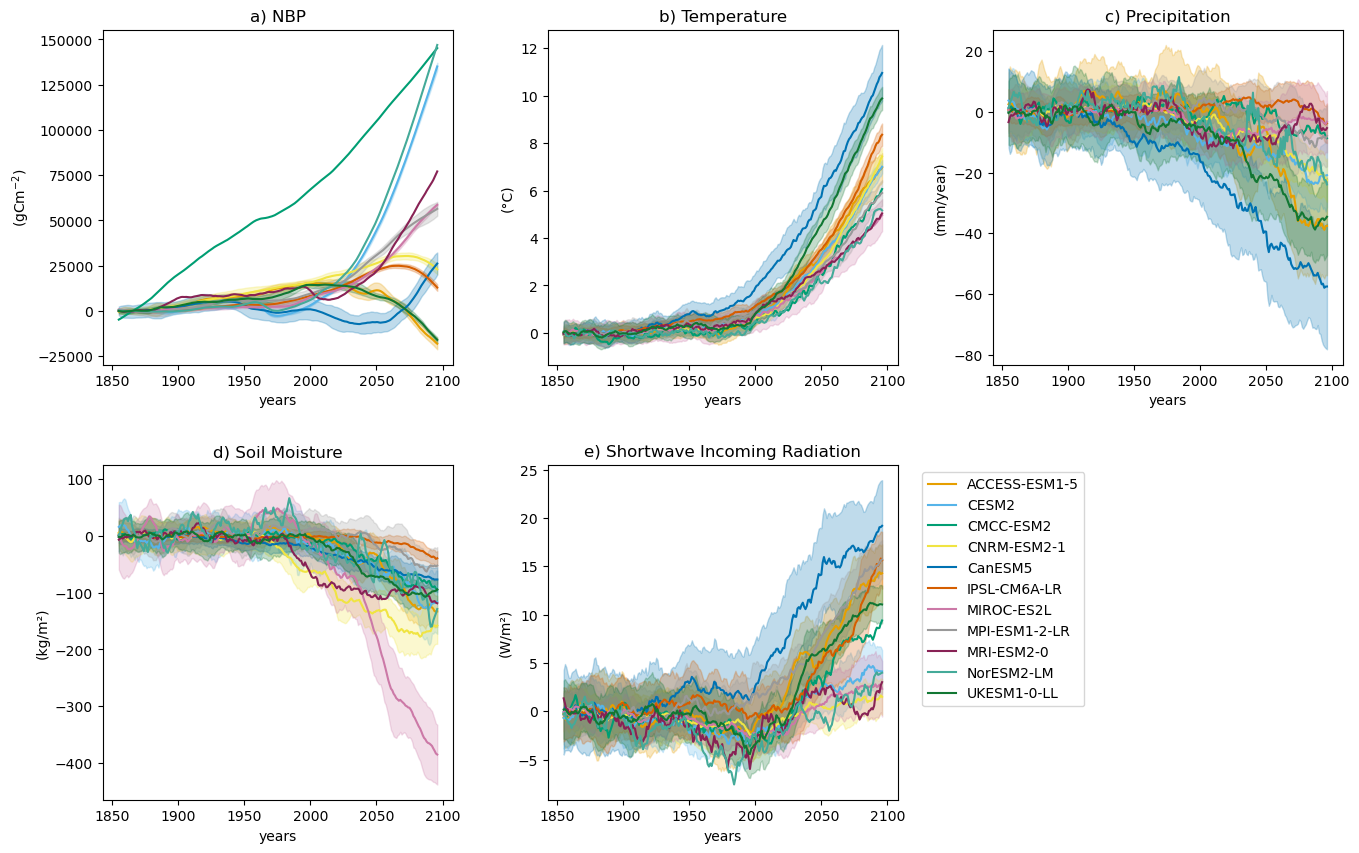

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 3x3 grid
fig.subplots_adjust(hspace=0.3, wspace=0.27)       # Spacing between plots

# Define colors for each model
colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 

colors = {model: colorblind_12[i] for i, model in enumerate(esm)}

# List of variables (columns) to plot, assuming df_amz_ymean has the required columns
variables = ["nbp", "tas", "pr", "mrso", "rsds"]
y_labels = {
    "nbp": "(gCm$^{-2}$)",
    "tas": "(°C)",
    "pr": "(mm/year)",
    "mrso": "(kg/m²)",
    "rsds": "(W/m²)"
}
titles = {
    "nbp": "a) NBP",
    "tas": "b) Temperature",
    "pr": "c) Precipitation",
    "mrso": "d) Soil Moisture",
    "rsds": "e) Shortwave Incoming Radiation"
}

# Plot each variable in its own subplot
for i, var in enumerate(variables):
    ax = axes.flatten()[i]   # Flatten the 3x3 grid to index subplots linearly
    for m, mm in enumerate(esm):

        trend = df_amz_ymean[f'{var} ' + mm] - df_amz_ymean[f'{var} ' + mm].iloc[0:31].mean()
        trend_std = df_amz_ystd[f'{var} ' + mm]
        ax.plot((trend).rolling(10, center=True).mean(), label=mm, color=colors[mm])
        ax.fill_between(trend.reset_index()["time"],
                        trend.rolling(10, center=True).mean() - trend_std.rolling(10, center=True).mean(),
                        trend.rolling(10, center=True).mean() + trend_std.rolling(10, center=True).mean(),
                        alpha=0.25, color=colors[mm], label='_nolegend_')

    # Set labels and title
    ax.set_xlabel("years")
    ax.set_ylabel(f"{var}")
    # ax.set_ylim(-80, 1400)
    # ax.axvline(df_amz_ymean.iloc[30]["ppm"], color="grey", alpha=0.7)
    ax.set_ylabel(y_labels.get(var, f"{var}"))  # Use unique label or fallback to variable name
    ax.set_title(titles.get(var, f"{var}"))

fig.delaxes(axes.flatten()[5])

# Add legend on the last non-empty plot
ax.legend(esm, loc='upper left', bbox_to_anchor=(1.05, 1))

# plt.tight_layout()
plt.show()
plt.close()

title = "Figure_1"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)

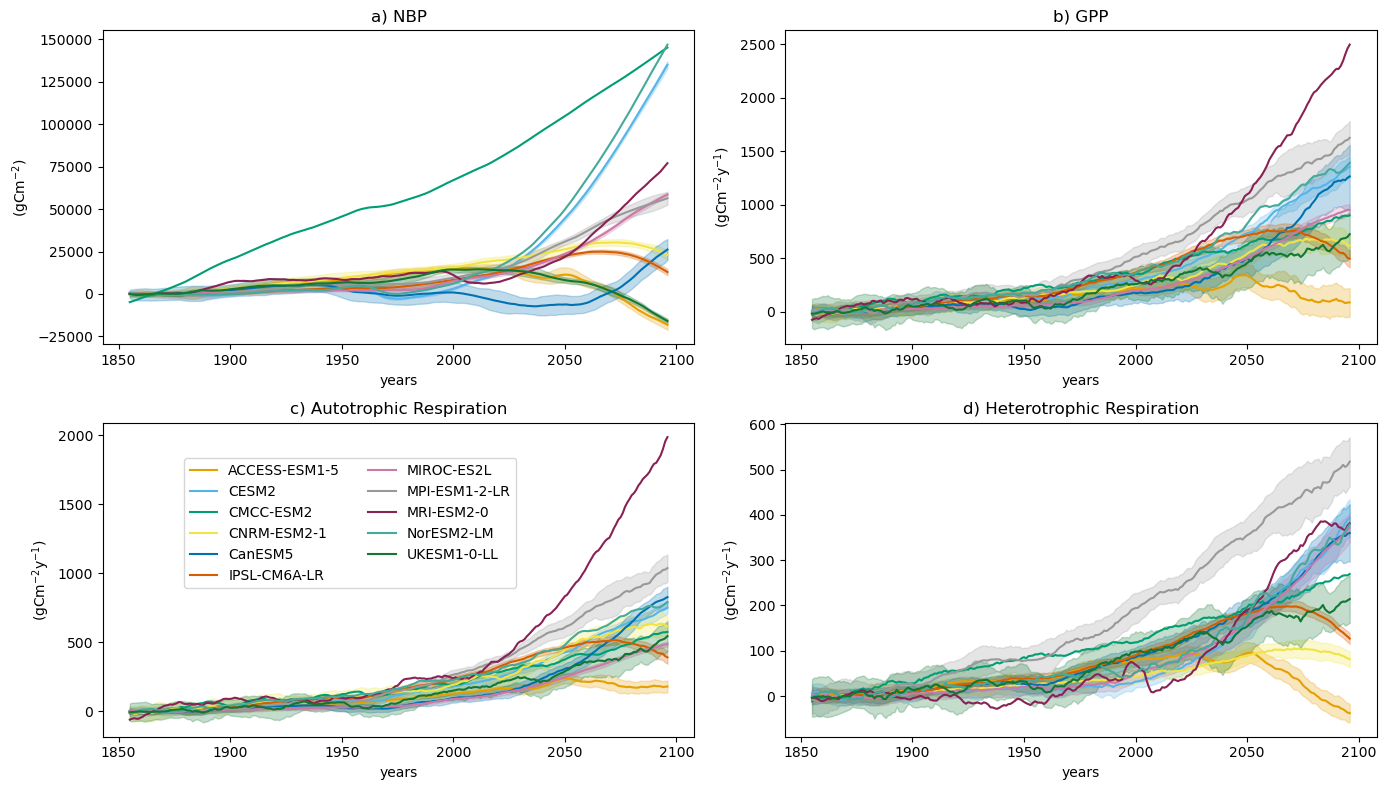

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 3x3 grid
fig.subplots_adjust(hspace=0.3, wspace=0.3)       # Spacing between plots

# Define colors for each model
colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 

colors = {model: colorblind_12[i] for i, model in enumerate(esm)}

# List of variables (columns) to plot, assuming df_amz_ymean has the required columns
variables = ["nbp", "gpp", "ra", "rh"]
y_labels = {
    "nbp": "(gCm$^{-2}$)",
    "gpp": "(gCm$^{-2}$y$^{-1}$)",
    "ra": "(gCm$^{-2}$y$^{-1}$)",
    "rh": "(gCm$^{-2}$y$^{-1}$)"
    }
titles = {
    "nbp": "a) NBP",
    "gpp": "b) GPP",
    "ra": "c) Autotrophic Respiration",
    "rh": "d) Heterotrophic Respiration"
    }
# Plot each variable in its own subplot
for i, var in enumerate(variables):
    ax = axes.flatten()[i]   # Flatten the 3x3 grid to index subplots linearly
    for m, mm in enumerate(esm):

        trend = df_amz_ymean[f'{var} ' + mm] - df_amz_ymean[f'{var} ' + mm].iloc[0:31].mean()
        trend_std = df_amz_ystd[f'{var} ' + mm]
        ax.plot((trend).rolling(10, center=True).mean(), label=mm, color=colors[mm])
        ax.fill_between(trend.reset_index()["time"],
                        trend.rolling(10, center=True).mean() - trend_std.rolling(10, center=True).mean(),
                        trend.rolling(10, center=True).mean() + trend_std.rolling(10, center=True).mean(),
                        alpha=0.25, color=colors[mm], label='_nolegend_')

    # Set labels and title
    ax.set_xlabel("years")
    ax.set_ylabel(f"{var}")
    # ax.set_ylim(-80, 1400)
    # ax.axvline(df_amz_ymean.iloc[30]["ppm"], color="grey", alpha=0.7)
    ax.set_ylabel(y_labels.get(var, f"{var}"))  # Use unique label or fallback to variable name
    ax.set_title(titles.get(var, f"{var}"))
    
# Add legend on the last non-empty plot
fig.legend(esm, loc='lower left', bbox_to_anchor=(0.13, 0.25), ncol = 2)

plt.tight_layout()
plt.show()
plt.close()
title = "Figure_S5"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)

Statistics

In [44]:
# mean values

for var in ["nep","nbp", "pr", "mrso", "tas", "rsds", "gpp", "ra", "rh"]:
    
    test = df_amz_ymean.loc[:, df_amz_ymean.columns.str.startswith(var)] - df_amz_ymean.loc[:, df_amz_ymean.columns.str.startswith(var)].iloc[0:11].mean()
    df_new = (df_amz_ymean - df_amz_ymean.mean())/df_amz_ymean.std()
    test_new = df_new.loc[:, df_new.columns.str.startswith(var)]# - df_new.loc[:, df_new.columns.str.startswith(var)].iloc[0:11].mean()

    print(f"{var} multi-model mean: " + str(test.iloc[-1].mean()))
    print(f"{var} multi-model std: " + str(test.iloc[-1].std()))
    print(f"{var} multi-model standardized std: " + str(test_new.iloc[-1].std()))


nep multi-model mean: 30.49308280267059
nep multi-model std: 124.37172045776406
nep multi-model standardized std: 1.4561298797462732
nbp multi-model mean: 61683.66199502323
nbp multi-model std: 66543.55718103737
nbp multi-model standardized std: 2.673289875142208
pr multi-model mean: -20.996943754802352
pr multi-model std: 19.62171175036702
pr multi-model standardized std: 1.1648054679488318
mrso multi-model mean: -118.0694389241533
mrso multi-model std: 101.69225579322203
mrso multi-model standardized std: 0.8464082862154285
tas multi-model mean: 7.310434386917174
tas multi-model std: 2.244612435532478
tas multi-model standardized std: 0.29622794001089325
rsds multi-model mean: 8.999936370179269
rsds multi-model std: 7.293323618061937
rsds multi-model standardized std: 0.987940702329303
gpp multi-model mean: 1148.8489413624059
gpp multi-model std: 753.5963831898708
gpp multi-model standardized std: 1.1269240252360981
ra multi-model mean: 787.9349724532663
ra multi-model std: 548.71338

## Validation

Reanalysis:

In [67]:
# Carbon fluxes convertion
ds_nep_flux = ds_nep_flux * 365 * -1
ds_nep_flux.attrs['units'] = 'gC m-2 y-1'

ds_gpp_flux = ds_gpp_flux * 365
ds_gpp_flux.attrs['units'] = 'gC m-2 y-1'

ds_ter_flux = ds_ter_flux * 365
ds_ter_flux.attrs['units'] = 'gC m-2 y-1' 

# Energy fluxes convertion
ds_h_flux = ds_h_flux * 1/0.0864        # 1J = 1W*s
ds_h_flux.attrs['units'] = 'W m-2'

ds_le_flux = ds_le_flux * 1/0.0864      # 1J = 1W*s
ds_le_flux.attrs['units'] = 'W m-2'

ds_rn_flux = ds_rn_flux * 1/0.0864      # 1J = 1W*s
ds_rn_flux.attrs['units'] = 'W m-2' 

ds_et_flux = ds_le_flux * (1/30) * (1/2.453)
ds_et_flux.attrs['units'] = 'mm month-1'

# Precipitation  & Soil Moisture conversion
ds_pr_era5 = ds_pr_era5 * 1000  # convert meter to mm/day by multiplying with 1000*24/step (step is 24 hrs in this case)
ds_pr_era5 = ds_pr_era5 * ds_pr_era5.time.dt.days_in_month
ds_pr_era5.attrs['units'] = 'mm month-1'

ds_mrso_era5 = ds_mrso_era5 
ds_mrso_era5.attrs['units'] = 'kg m-2'

ds_tas_era5 = ds_tas_era5 - 273.15
ds_tas_era5.attrs['units'] = '°C'

In [68]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

# Define Longitude from -180 to 180
ds_nep_flux = lon180(ds_nep_flux); ds_gpp_flux = lon180(ds_gpp_flux); ds_ter_flux = lon180(ds_ter_flux)
ds_le_flux = lon180(ds_le_flux); ds_rn_flux = lon180(ds_rn_flux)
ds_pr_era5 = lon180(ds_pr_era5); ds_tas_era5 = lon180(ds_tas_era5); ds_mrso_era5 = lon180(ds_mrso_era5)

# Select period from 197901 to 201312
ds_nep_flux = ds_nep_flux.sel(time = slice("1979-01", "2013-12")); ds_gpp_flux = ds_gpp_flux.sel(time = slice("1979-01", "2013-12")); ds_ter_flux = ds_ter_flux.sel(time = slice("1979-01", "2013-12"))
ds_le_flux = ds_le_flux.sel(time = slice("1979-01", "2013-12")); ds_rn_flux = ds_rn_flux.sel(time = slice("1979-01", "2013-12"))
ds_pr_era5 = ds_pr_era5.sel(time = slice("1979-01", "2013-12")); ds_tas_era5 = ds_tas_era5.sel(time = slice("1979-01", "2013-12")); ds_mrso_era5 = ds_mrso_era5.sel(time = slice("1979-01", "2013-12"))

# Select lon lat of Amazon basin
ds_nep_flux = ds_nep_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_gpp_flux = ds_gpp_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_ter_flux = ds_ter_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_le_flux = ds_le_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_rn_flux = ds_rn_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_pr_era5 = ds_pr_era5.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_tas_era5 = ds_tas_era5.sel(lon = slice(-85, -30), lat = slice(-30,15))

# Regrid ERA5 data to FLUXCOM resolution
ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 15, 1)

regrid_nep_flux = xe.Regridder(ds_nep_flux, ds_out, "bilinear")
regrid_pr_era5 = xe.Regridder(ds_pr_era5, ds_out, "bilinear")
regrid_tas_era5 = xe.Regridder(ds_tas_era5, ds_out, "bilinear")
regrid_mrso_era5 = xe.Regridder(ds_mrso_era5, ds_out, "bilinear")

ds_nep_flux = regrid_nep_flux(ds_nep_flux, keep_attrs=True); ds_gpp_flux = regrid_nep_flux(ds_gpp_flux, keep_attrs=True); ds_ter_flux = regrid_nep_flux(ds_ter_flux, keep_attrs=True)
ds_le_flux = regrid_nep_flux(ds_le_flux, keep_attrs=True); ds_rn_flux = regrid_nep_flux(ds_rn_flux, keep_attrs=True)
ds_pr_era5 = regrid_pr_era5(ds_pr_era5, keep_attrs=True); ds_tas_era5 = regrid_tas_era5(ds_tas_era5, keep_attrs=True); ds_mrso_era5 = regrid_mrso_era5(ds_mrso_era5, keep_attrs=True)


In [69]:
# Compute multi-year monthly mean 
ds_pr_era5_monmean = ds_pr_era5.groupby('time.month').mean(dim = 'time')
ds_tas_era5_monmean = ds_tas_era5.groupby('time.month').mean(dim = 'time')
ds_mrso_era5_monmean = ds_mrso_era5.groupby('time.month').mean(dim = 'time')

ds_pr_era5_amz = zonal_stat(ds_pr_era5_monmean, geodf).sel(region = 1)
ds_tas_era5_amz = zonal_stat(ds_tas_era5_monmean, geodf).sel(region = 1)
ds_mrso_era5_amz = zonal_stat(ds_mrso_era5_monmean, geodf).sel(region = 1)


In [70]:
ds_rn_flux_monmean = ds_rn_flux.groupby('time.month').mean(dim = 'time')
ds_nep_flux_monmean = ds_nep_flux.groupby('time.month').mean(dim = 'time')
ds_gpp_flux_monmean = ds_gpp_flux.groupby('time.month').mean(dim = 'time')
ds_ter_flux_monmean = ds_ter_flux.groupby('time.month').mean(dim = 'time')

ds_nep_flux_amz = zonal_stat(ds_nep_flux_monmean, geodf).sel(region = 1)
ds_gpp_flux_amz = zonal_stat(ds_gpp_flux_monmean, geodf).sel(region = 1)
ds_ter_flux_amz = zonal_stat(ds_ter_flux_monmean, geodf).sel(region = 1)
ds_rn_flux_amz = zonal_stat(ds_rn_flux_monmean, geodf).sel(region = 1)

ESM

In [71]:
# Monthly means
df_amz_mon = df_amz.loc[(df_amz.index.year > 1978) &  (df_amz.index.year < 2014)]
df_amz_mon = df_amz_mon.groupby(by=[df_amz_mon.index.month]).mean()
df_amz_monmean = df_amz_mon.groupby(df_amz_mon.columns, axis=1).mean()

### Seasonality bias

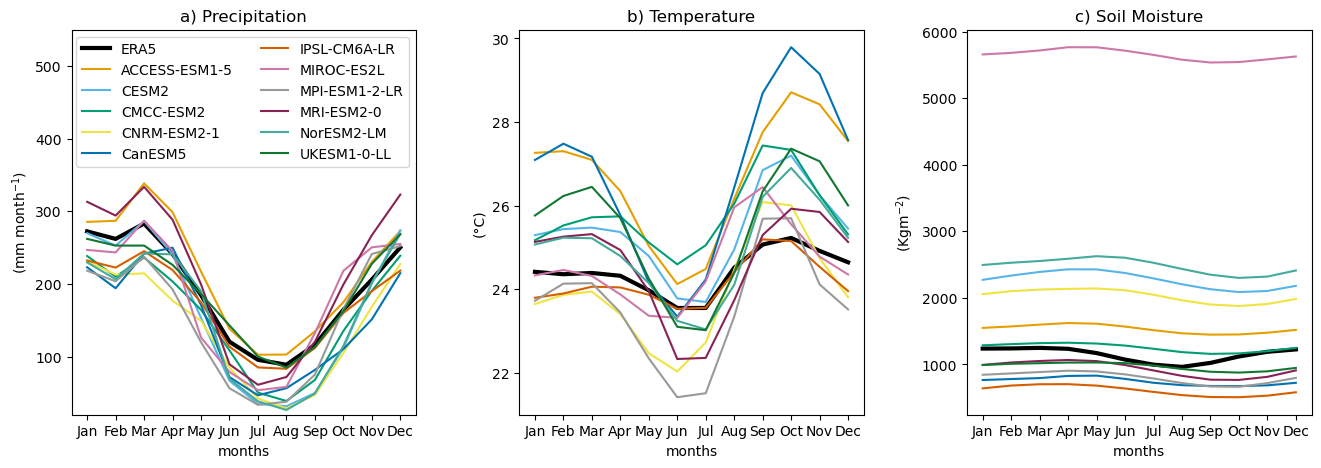

In [72]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Define ESM models and add ERA5
esm_plot = esm.copy()
esm_plot.insert(0, "ERA5")

# Define months
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Define consistent colors and line styles
colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 

colors = {model: colorblind_12[i] for i, model in enumerate(esm)}

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

# Precipitation plot
ax = axes.flatten()[0]   # Flatten the 3x3 grid to index subplots linearly
ax.plot(ds_pr_era5_amz, color='black', linewidth=3, label="ERA5")
for i, item in enumerate(esm_plot[1:]):  # Skip ERA5 as it was already plotted
    ax.plot(months, df_amz_monmean["pr " + item], label=item, color=colors[item])
ax.set_ylabel("(mm month$^{-1}$)")
ax.set_xlabel("months")
ax.set_ylim(20, 550)
ax.set_title("a) Precipitation")
ax.legend(esm_plot, fontsize=10, ncol=2, loc="upper right")

# Temperature plot
ax = axes.flatten()[1]
ax.plot(ds_tas_era5_amz, color='black', linewidth=3, label="ERA5")
for i, item in enumerate(esm_plot[1:]):  # Skip ERA5 as it was already plotted
    ax.plot(months, df_amz_monmean["tas " + item], label=item, color=colors[item])
ax.set_ylabel("(°C)")
ax.set_xlabel("months")
ax.set_title("b) Temperature")

# Soil Moisture plot
ax = axes.flatten()[2]
ax.plot(ds_mrso_era5_amz, color='black', linewidth=3, label="ERA5")
for i, item in enumerate(esm_plot[1:]):  # Skip ERA5 as it was already plotted
    ax.plot(months, df_amz_monmean["mrso " + item], label=item, color=colors[item])
ax.set_ylabel("(Kgm$^{-2}$)")
ax.set_xlabel("months")
ax.set_title("c) Soil Moisture")

plt.show()
plt.close()

title = "Figure_S2"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)

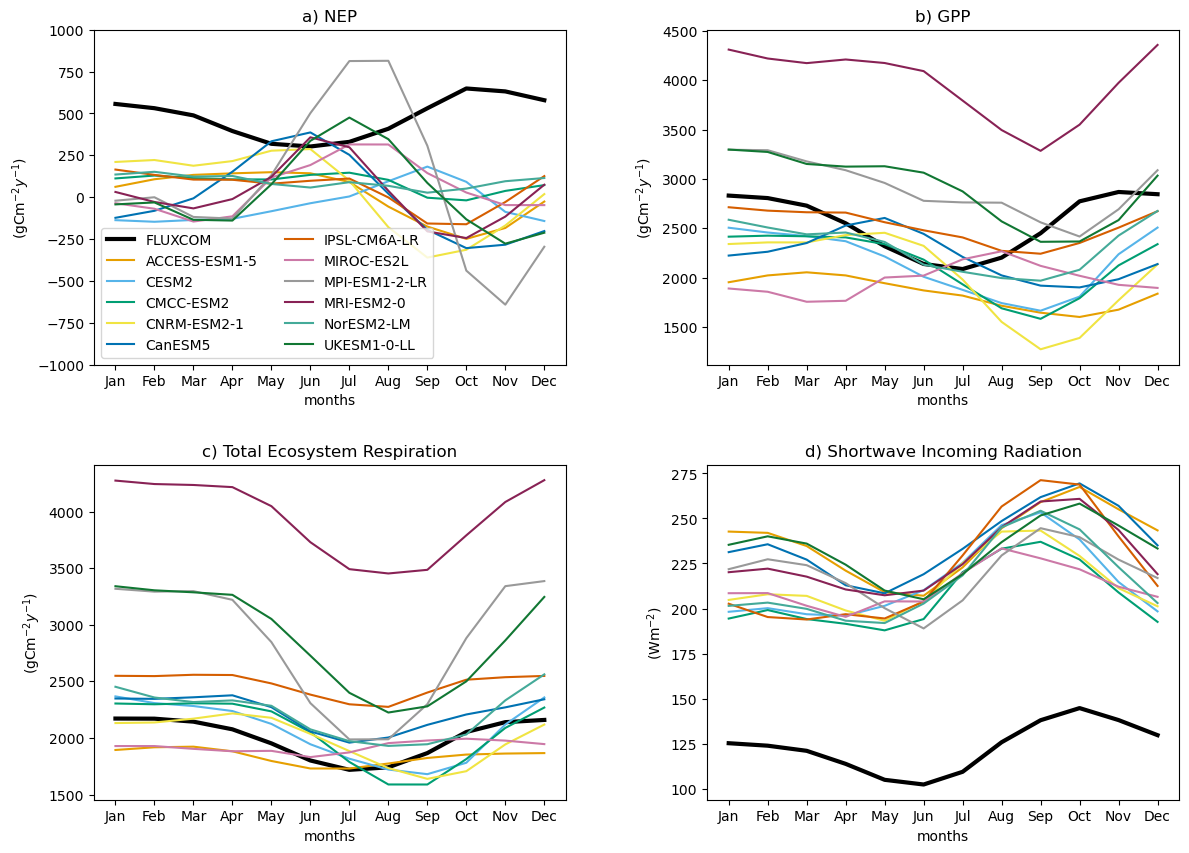

In [73]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Define ESM models and add FLUXCOM
esm_plot = esm.copy()
esm_plot.insert(0, "FLUXCOM")

# Define months
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Define consistent colors and line styles
colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 

colors = {model: colorblind_12[i] for i, model in enumerate(esm)}

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

# Precipitation plot
ax = axes.flatten()[0]   # Flatten the 3x3 grid to index subplots linearly
ax.plot(ds_nep_flux_amz, color='black', linewidth=3, label="FLUXCOM")
for i, item in enumerate(esm_plot[1:]):  # Skip FLUXCOM as it was already plotted
    ax.plot(months, df_amz_monmean["nep " + item], label=item, color=colors[item])
ax.set_ylabel("(gCm$^{-2}y^{-1}$)")
ax.set_xlabel("months")
ax.set_ylim(-1000, 1000)
ax.set_title("a) NEP")
ax.legend(esm_plot, fontsize=10, ncol=2, loc="lower left")

# Temperature plot
ax = axes.flatten()[1]
ax.plot(ds_gpp_flux_amz, color='black', linewidth=3, label="FLUXCOM")
for i, item in enumerate(esm_plot[1:]):  # Skip FLUXCOM as it was already plotted
    ax.plot(months, df_amz_monmean["gpp " + item], label=item, color=colors[item])
ax.set_ylabel("(gCm$^{-2}y^{-1}$)")
ax.set_xlabel("months")
ax.set_title("b) GPP")

# Soil Moisture plot
ax = axes.flatten()[2]
ax.plot(ds_ter_flux_amz, color='black', linewidth=3, label="FLUXCOM")
for i, item in enumerate(esm_plot[1:]):  # Skip FLUXCOM as it was already plotted
    ax.plot(months, df_amz_monmean["ra " + item] + df_amz_monmean["rh " + item], label=item, color=colors[item])
ax.set_ylabel("(gCm$^{-2}y^{-1}$)")
ax.set_xlabel("months")
ax.set_title("c) Total Ecosystem Respiration")

ax = axes.flatten()[3]
ax.plot(ds_rn_flux_amz, color='black', linewidth=3, label="FLUXCOM")
for i, item in enumerate(esm_plot[1:]):  # Skip FLUXCOM as it was already plotted
    ax.plot(months, df_amz_monmean["rsds " + item], label=item, color=colors[item])
ax.set_ylabel("(Wm$^{-2}$)")
ax.set_xlabel("months")
ax.set_title("d) Shortwave Incoming Radiation")

plt.show()
plt.close()

title = "Figure_S3"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)

### Boxplots

In [74]:
# Monthly values
df_amz_mon = df_amz.loc[(df_amz.index.year > 1978) &  (df_amz.index.year < 2014)]
df_amz_monmean = df_amz_mon.groupby(df_amz_mon.columns, axis=1).mean()

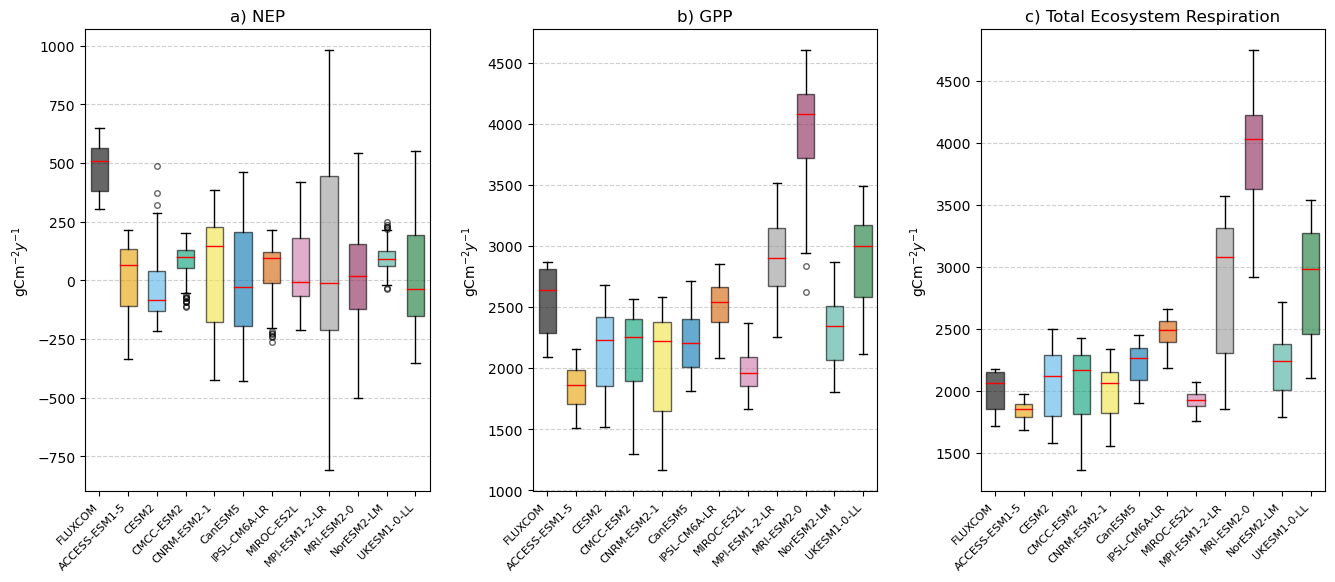

In [77]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Define ESM models and add FLUXCOM
esm_plot = esm.copy()
esm_plot.insert(0, "FLUXCOM")

# Define consistent colors for the other ESMs
colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 
colors = [colorblind_12[i] for i in range(len(esm))]  # Colors for the ESM models

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Define x positions for boxplots
x_positions = range(len(esm_plot))  # Unique positions for each model

# NEP Plot (a)
ax = axes[0]
data = [ds_nep_flux_amz] + [df_amz_monmean["nep " + item] for item in esm]
boxplots = ax.boxplot(data, positions=x_positions, patch_artist=True, widths=0.6)

# Style FLUXCOM (first boxplot) in black
boxplots["boxes"][0].set(facecolor="black", alpha=0.6)
boxplots["medians"][0].set(color="red")
boxplots["fliers"][0].set(marker="o", markersize=4, color="black", alpha=0.6)

# Style the remaining boxplots with the tab20 colormap
for i, box in enumerate(boxplots["boxes"][1:], start=1):
    box.set(facecolor=colors[i - 1], alpha=0.6)  # Skip FLUXCOM
    boxplots["medians"][i].set(color="red")
    boxplots["fliers"][i].set(marker="o", markersize=4, color="black", alpha=0.6)

# Set ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(esm_plot, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("gCm$^{-2}y^{-1}$")
ax.set_xlabel("")
ax.set_title("a) NEP")
ax.grid(axis="y", linestyle="--", alpha=0.6)

# GPP Plot (b)
ax = axes[1]
data = [ds_gpp_flux_amz] + [df_amz_monmean["gpp " + item] for item in esm]
boxplots = ax.boxplot(data, positions=x_positions, patch_artist=True, widths=0.6)

# Style FLUXCOM (first boxplot) in black
boxplots["boxes"][0].set(facecolor="black", alpha=0.6)
boxplots["medians"][0].set(color="red")
boxplots["fliers"][0].set(marker="o", markersize=4, color="black", alpha=0.6)

# Style the remaining boxplots with the tab20 colormap
for i, box in enumerate(boxplots["boxes"][1:], start=1):
    box.set(facecolor=colors[i - 1], alpha=0.6)
    boxplots["medians"][i].set(color="red")
    boxplots["fliers"][i].set(marker="o", markersize=4, color="black", alpha=0.6)

# Set ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(esm_plot, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("gCm$^{-2}y^{-1}$")
ax.set_xlabel("")
ax.set_title("b) GPP")
ax.grid(axis="y", linestyle="--", alpha=0.6)

# TER Plot (c)
ax = axes[2]
data = [ds_ter_flux_amz] + [df_amz_monmean["ra " + item] + df_amz_monmean["rh " + item] for item in esm]
boxplots = ax.boxplot(data, positions=x_positions, patch_artist=True, widths=0.6)

# Style FLUXCOM (first boxplot) in black
boxplots["boxes"][0].set(facecolor="black", alpha=0.6)
boxplots["medians"][0].set(color="red")
boxplots["fliers"][0].set(marker="o", markersize=4, color="black", alpha=0.6)

# Style the remaining boxplots with the tab20 colormap
for i, box in enumerate(boxplots["boxes"][1:], start=1):
    box.set(facecolor=colors[i - 1], alpha=0.6)
    boxplots["medians"][i].set(color="red")
    boxplots["fliers"][i].set(marker="o", markersize=4, color="black", alpha=0.6)

# Set ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(esm_plot, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("gCm$^{-2}y^{-1}$")
ax.set_xlabel("")
ax.set_title("c) Total Ecosystem Respiration")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()
plt.close()

title = "Figure_S4"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)